# Thesis Fisher info plots - 5Try - M / Ratio_conj + comparison

5/5


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import scipy as sp
import scipy.stats as spst
import scipy.interpolate as spint
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.utils import io
import progress

from experimentlauncher import ExperimentLauncher
from dataio import DataIO
import plots_experimental_data
import em_circularmixture_parametrickappa


# import matplotlib.animation as plt_anim
from mpl_toolkits.mplot3d import Axes3D

import re
import inspect
import imp

import utils
import load_experimental_data

from plots_fitexperiment_papertheo import PlotsFitExperimentAllTPaperTheo
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2})

In [7]:
with io.capture_output(display=False, stdout=True) as captured:
    %run reloader_fisher2016_random_Mratio_5try_240818.py

In [8]:
dataio = DataIO(output_folder=generator_module.pbs_submission_infos['simul_out_dir'] + '/outputs/', 
                label='thesis_' + dataset_infos['save_output_filename'])
dataio.make_link_output_to_dropbox(dropbox_current_experiment_folder='fisherinfo_new_2016')

=== FileIO ready: /nfs/data3/lmatthey/visual_working_mem/fisherinfo_new_2016/fisher2016_random_Mratio_5try_repetitions10_240818/outputs/thesis_mratio_rnd-<module>-5d6911b9-9a7d-4a85-9766-58ea1529c0de ===
Doing dropbox symlink:  /nfs/data3/lmatthey/visual_working_mem/fisherinfo_new_2016/fisher2016_random_Mratio_5try_repetitions10_240818/outputs/ /nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/code/git-bayesian-visual-working-memory/Experiments/fisherinfo_new_2016/fisher2016_random_Mratio_5try_repetitions10_240818_outputs
Symlink failed:  /nfs/data3/lmatthey/visual_working_mem/fisherinfo_new_2016/fisher2016_random_Mratio_5try_repetitions10_240818/outputs/ /nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/code/git-bayesian-visual-working-memory/Experiments/fisherinfo_new_2016/fisher2016_random_Mratio_5try_repetitions10_240818_outputs


In [250]:
def avgstd_axis(array_name, array, axis=-1, out=None):
    if out is None:
        out = []
    out.append((array_name, utils.nanmean(array, axis=axis)))
    out.append((array_name + '_sigma', utils.nanstd(array, axis=axis)))
    return out

def avgstd_discardsecondlastaxis(array_name, array, axis=-1, out=None):
    if out is None:
        out = []
    out.append((array_name, utils.nanmean(array[..., 0, :], axis=axis)))
    out.append((array_name + '_sigma', utils.nanstd(array[..., 0, :], axis=axis)))
    return out

def avgstd_flatten(array_name, array, axis=-1, out=None):
    if out is None:
        out = []
    out.append((array_name, utils.nanmean(array.flatten(), axis=axis)))
    out.append((array_name + '_sigma', utils.nanstd(array.flatten(), axis=axis)))
    return out
    
def process_scalar(array_name, array):
    out = []
    avgstd_axis(array_name, array, out=out)
    avgstd_axis(array_name + "_stddev", (2./array)**0.5, out=out)
    return out
    
def process_fi(array_name, array):
    out = []
    avgstd_discardsecondlastaxis(array_name, array, out=out)
    avgstd_discardsecondlastaxis(array_name + "_stddev", (2./array)**0.5, out=out)
    
    return out

def process_marginal_fi(array_name, array):
    out = []
    
    # Marginal FI/Inv FI have (mean, std), just keep mean
    array = array[..., 0, :]
    avgstd_axis(array_name, array, out=out)
    
    if array_name.find('inv') > -1:
        avgstd_axis(array_name + "_stddev", (2.*array)**0.5, out=out)
    else:
        avgstd_axis(array_name + "_stddev", (2./array)**0.5, out=out)
    
    return out

def process_em_fits(array_name, array):
    out = []
    for col_i, colname in enumerate(
            ['kappa', 'target', 'nontargets', 'random', 'LL', 'bic']):
        out = avgstd_axis(array_name + "_" + colname, array[:, col_i], out=out)
        
    out = avgstd_axis(array_name + '_fidelity', 1./utils.kappa_to_stddev(array[:, 0])**2., out=out)
    out = avgstd_axis(array_name + '_stddev', utils.kappa_to_stddev(array[:, 0]), out=out)
    
    return out

    
def construct_pandas_dataframe(data_pbs, pandas_columns_with_processing, num_repetitions):
    parameter_names_sorted = data_pbs.dataset_infos['parameters']
    filter_data = None
    result_parameters_flat = None

    pandas_column_data = []

    for result_array_name, result_processing in pandas_columns_with_processing:
        # Extract data
        res_array = np.array(data_pbs.dict_arrays[result_array_name]['results_flat'])

        # Filter completed only
        if filter_data is None:
            repeats_completed = data_pbs.dict_arrays[result_array_name]['repeats_completed']
            filter_data = repeats_completed == (num_repetitions - 1)
        res_array = res_array[filter_data]

        # Keep parameters
        if result_parameters_flat is None:
            result_parameters_flat = np.array(data_pbs.dict_arrays[result_array_name]['parameters_flat'])
            result_parameters_flat = result_parameters_flat[filter_data]

        # Transform into list of columns for Pandas
        pandas_column_data.extend(result_processing['process'](result_processing['name'], res_array))

    # Add all parameters to Pandas columns
    for param_i, param_name in enumerate(parameter_names_sorted):
        pandas_column_data.append((param_name, result_parameters_flat[:, param_i]))
    
    df_out = pd.DataFrame.from_items(pandas_column_data)
    
    # Remove NaN
    df_out = df_out.dropna()
    
    return df_out

In [251]:
# data_pbs.loaded_data['parameters_uniques']
xx = np.array(data_pbs.dict_arrays['result_em_fits']['results_flat'])
print xx.shape
# process_marginal_fi('result_marginal_FI', xx)[0][1]
dict(process_em_fits('em', xx))['em_fidelity'][0]

(10000, 6, 10)


9.6551173550228455

In [102]:
for k, v in data_pbs.dict_arrays.iteritems():
    out1 = avgstd_axis(k, v['results_flat'][0])
    print k, out1[1].shape
    out2 = avgstd_flatten(k, v['results_flat'][0])
    print k, out2[1].shape

result_FI_rc_theocov (300,)
result_FI_rc_theocov ()
result_FI_rc_theo_circulant (300,)
result_FI_rc_theo_circulant ()
result_all_precisions ()
result_all_precisions ()
result_em_fits (6,)
result_em_fits ()
result_FI_rc_curv (300,)
result_FI_rc_curv ()
result_marginal_FI (2,)
result_marginal_FI ()
result_marginal_inv_FI (2,)
result_marginal_inv_FI ()
result_FI_rc_theo_largeN ()
result_FI_rc_theo_largeN ()
result_FI_rc_theo (300,)
result_FI_rc_theo ()


In [252]:
def remove_outliers(df, n_stddev=5):
    outliers = np.sum(np.abs(spst.zscore(df)) < n_stddev, axis=-1)
    return df[outliers >= outliers.max()]

def df_add_quantize_parameters(df, parameters, nQuantiles):
    param_qbins = dict()
    param_qbins_middle = dict()

    for param_name in parameters:
        param_factored, param_qbins[param_name] = pd.qcut(df[param_name], nQuantiles, retbins=True, labels=False)
        param_qbins_middle[param_name] = ((param_qbins[param_name][:-1] + param_qbins[param_name][1:])/2.
                                         ).astype(df[param_name].dtype)
        df.loc[:, (param_name + "_qi")] = param_factored
    
    return df, param_qbins, param_qbins_middle

def filter_dataframe(df, parameters_values):
    filter_mask = None
    for key, value in parameters_values.iteritems():
        new_filter = (df[key] == value)
        if filter_mask is None:
            filter_mask = new_filter
        else:
            filter_mask = filter_mask & new_filter
    
    if filter_mask is None:
        return df
    else:
        return df[filter_mask]

def filter_quantized_param(df, target_parameters, param_qbins):
    quantized_parameters_targets = dict()
    
    for key, value in target_parameters.iteritems():
        target_qi = (np.digitize(value, param_qbins[key], right=False).item() - 1)
        quantized_parameters_targets[key + "_qi"] = target_qi

    return filter_dataframe(df, quantized_parameters_targets)

In [253]:
# Extract data
num_repetitions = generator_module.num_repetitions
parameter_names_sorted = data_pbs.dataset_infos['parameters']
all_args_arr = np.array(data_pbs.loaded_data['args_list'])

In [312]:
pandas_columns_with_processing = [
    ('result_all_precisions', dict(name='precision', process=process_scalar)),
    ('result_FI_rc_curv', dict(name='fi_curv', process=process_fi)),
    ('result_FI_rc_theo', dict(name='fi_theo', process=process_fi)),
    ('result_FI_rc_theocov', dict(name='fi_theo_cov', process=process_fi)),
    ('result_FI_rc_theo_circulant', dict(name='fi_circ', process=process_fi)),
    ('result_FI_rc_theo_largeN', dict(name='fi_theo_largen', process=process_scalar)),
    ('result_marginal_FI', dict(name='fi_marginal', process=process_marginal_fi)),
    ('result_marginal_inv_FI', dict(name='inv_fi_marginal', process=process_marginal_fi)),
    ('result_em_fits', dict(name='emfit', process=process_em_fits)),
]

df_all_fits = construct_pandas_dataframe(data_pbs, pandas_columns_with_processing, num_repetitions)
df_all_fits.loc[:, ('M')] = df_all_fits.loc[:, ('M')].astype(int)


df_all_fits.loc[:, ('fi_fidelity_ratio')] = df_all_fits['fi_theo']/(2*df_all_fits['emfit_fidelity'])
df_all_fits.loc[:, ('fi_stddev_ratio')] = df_all_fits['fi_theo_stddev']/(df_all_fits['emfit_stddev'])
df_all_fits.loc[:, ('margfi_stddev_ratio')] = df_all_fits['inv_fi_marginal_stddev']/(df_all_fits['emfit_stddev'])

# Filter a bit
df_all_fits = df_all_fits[df_all_fits['inv_fi_marginal_stddev'] < 1.5*np.pi]

M_space = np.sort(df_all_fits['M'].unique())
ratio_conj_space = np.sort(df_all_fits['ratio_conj'].unique())


In [315]:
# Remove outliers
df_fits_filtered = remove_outliers(df_all_fits, 10)

In [316]:
df_fits_filtered.describe()

,precision,precision_sigma,precision_stddev,precision_stddev_sigma,fi_curv,fi_curv_sigma,fi_curv_stddev,fi_curv_stddev_sigma,fi_theo,fi_theo_sigma,...,emfit_bic_sigma,emfit_fidelity,emfit_fidelity_sigma,emfit_stddev,emfit_stddev_sigma,M,ratio_conj,fi_fidelity_ratio,fi_stddev_ratio,margfi_stddev_ratio
count,9871.000000,9871.000000,9871.000000,9871.000000,9871.000000,9871.000000,9871.000000,9871.000000,9871.000000,9871.000000,...,9871.000000,9871.000000,9871.000000,9871.000000,9871.000000,9871.000000,9871.000000,9871.000000,9871.000000,9871.000000
mean,144.884497,11.422501,0.155837,0.006239,305.982256,55.224372,0.107298,0.011828,300.038239,0.877622,...,23.681440,145.099707,11.454280,0.109752,0.004492,305.173741,0.504581,1.039733,0.979350,0.979350
std,82.567908,7.215199,0.118603,0.005377,174.438863,33.504358,0.075868,0.014599,170.257906,0.616928,...,5.676009,82.631752,7.233033,0.081406,0.004661,170.702170,0.285313,0.059414,0.026096,0.026096
min,1.018126,0.041752,0.081827,0.001087,2.359040,0.872306,0.054227,0.001268,1.948910,0.002132,...,6.844752,1.108698,0.095443,0.057860,0.000768,9.000000,0.010048,0.725758,0.814394,0.814394
25%,75.796577,5.502550,0.096697,0.003670,154.856158,27.701434,0.067169,0.005954,162.327269,0.409115,...,19.661249,75.997871,5.505715,0.068337,0.002592,169.000000,0.260358,1.011908,0.969807,0.969807
50%,142.824464,10.723069,0.118692,0.004742,304.415966,52.272888,0.082164,0.008103,282.696232,0.759769,...,23.404362,142.959561,10.741809,0.083836,0.003351,289.000000,0.503408,1.034885,0.980724,0.980724
75%,214.936923,16.409893,0.162735,0.006723,455.180875,78.880104,0.115352,0.012147,433.914440,1.214028,...,27.408943,215.096865,16.473577,0.114965,0.004745,441.000000,0.754176,1.058100,0.991502,0.991502
max,300.150043,38.078103,1.405957,0.077791,689.263147,184.136562,0.999855,0.260702,574.453126,4.783954,...,54.196973,300.150042,38.078088,0.952723,0.079392,576.000000,0.999980,1.498963,1.159904,1.159904


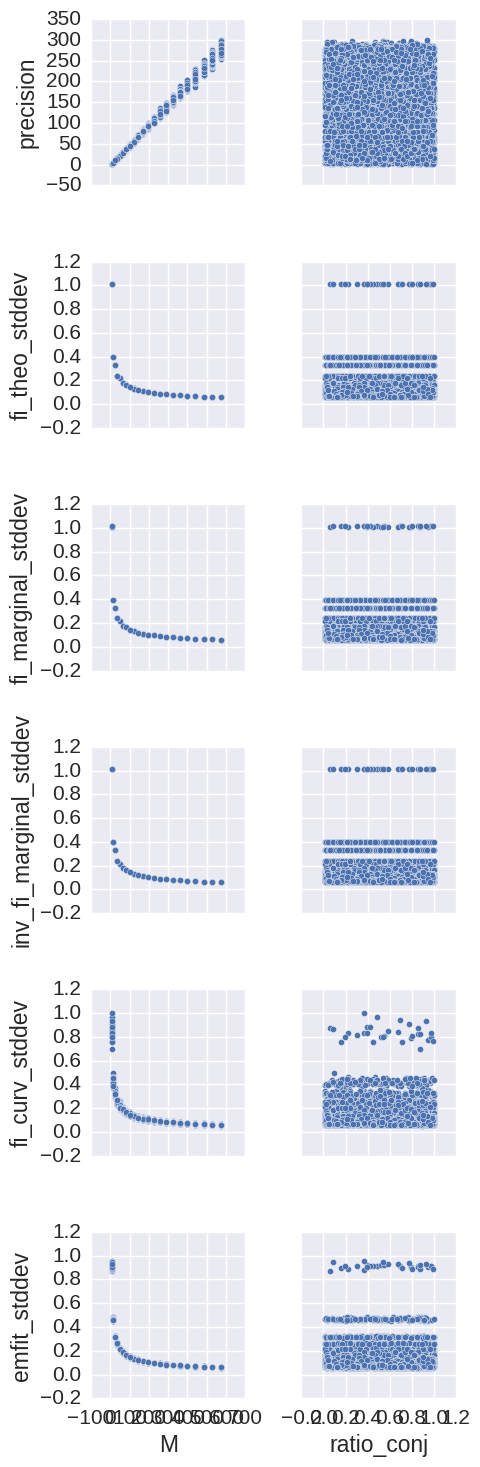

In [317]:
# Cross-correlation plots
g = sns.pairplot(
    df_fits_filtered,
    x_vars=['M', 'ratio_conj'],
    y_vars=['precision', 'fi_theo_stddev', 'fi_marginal_stddev', 'inv_fi_marginal_stddev', 
            'fi_curv_stddev', 'emfit_stddev']
)
# for ax in g.axes.flat:  
#     plt.setp(ax.get_xticklabels(), rotation=45)

## Quantize parameters

In [325]:
nQuantiles = 21
parameters = ['ratio_conj']

df_quantized, param_qbins, param_qbins_middle = df_add_quantize_parameters(df_fits_filtered, parameters, nQuantiles)

df_quantized.loc[:, 'fi_marginal_half'] = df_quantized['fi_marginal']/2
df_quantized.loc[:, 'fi_theo_half'] = df_quantized['fi_theo']/2

## 2D plot M/ratio_conj

In [326]:
def plot_mean_std_df(df, x_col, y_col, param_qbins_middle, xlabel=None, ylabel=None, ax=None):
    df_mean = df.groupby(x_col + "_qi").mean()
    df_std = df.groupby(x_col + "_qi").std()
    
    return utils.plot_mean_std_area(df_mean[x_col], #param_qbins_middle[x_col], 
                                    df_mean[y_col],
                                    df_std[y_col],
                                    xlabel=xlabel,
                                    ylabel=ylabel,
                                    ax_handle=ax,
                                    label=y_col
                                   )

In [327]:
def compute_spline_interpolation(df, interpolate_column, x_col='', y_col='', kx=3, ky=3, s=None):
    
    if interpolate_column + "_sigma" in df:
        w = 1./df[interpolate_column + "_sigma"]
    else:
        w = None
        
    return spint.SmoothBivariateSpline(df[x_col], df[y_col], df[interpolate_column], w=w, kx=kx, ky=ky, s=s)

def pcolor_2d_interpolated(df, target_column, x_col='M', y_col='rc_scale', 
                           title='', vmin=None, vmax=None, cmap='RdBu_r'):
    x_int_space = np.sort(df[x_col].unique())
    y_int_space = np.sort(df[y_col].unique())

    spline_int = compute_spline_interpolation(df, target_column, 
                                              x_col=x_col, y_col=y_col)
    return utils.pcolor_2d_data(spline_int(x_int_space, y_int_space),
                                x=x_int_space, 
                                y=y_int_space, 
                                xlabel=x_col, 
                                xlabel_format="%d", 
                                ylabel=y_col, 
                                title=title,
                                ticks_interpolate=15,
                                vmin=vmin,
                                vmax=vmax,
                                log_scale=False, 
                                cmap=cmap
                               )

In [328]:
df_avg = df_quantized.groupby(('M', 'ratio_conj')).mean().reset_index()

(<matplotlib.axes._subplots.AxesSubplot at 0x7efc3f7dc110>,
 <matplotlib.image.AxesImage at 0x7efc3b611d90>)

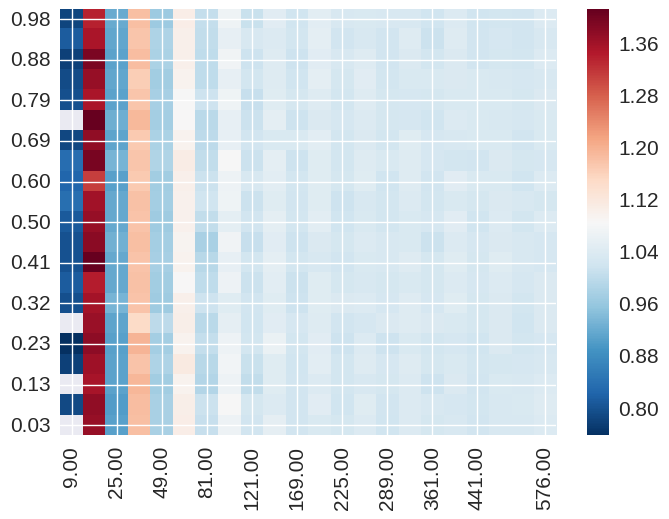

In [336]:
# value = 'precision'
value = 'fi_fidelity_ratio'

data_M_ratio = df_avg.pivot_table(index='M', columns='ratio_conj_qi', values=value).as_matrix()
utils.pcolor_2d_data(data_M_ratio, x=df_avg.M.unique(), y=param_qbins_middle['ratio_conj'], 
                     ticks_interpolate=11, cmap='RdBu_r')


(<matplotlib.axes._subplots.AxesSubplot at 0x7efc3b136250>,
 <matplotlib.image.AxesImage at 0x7efc3dfac6d0>)

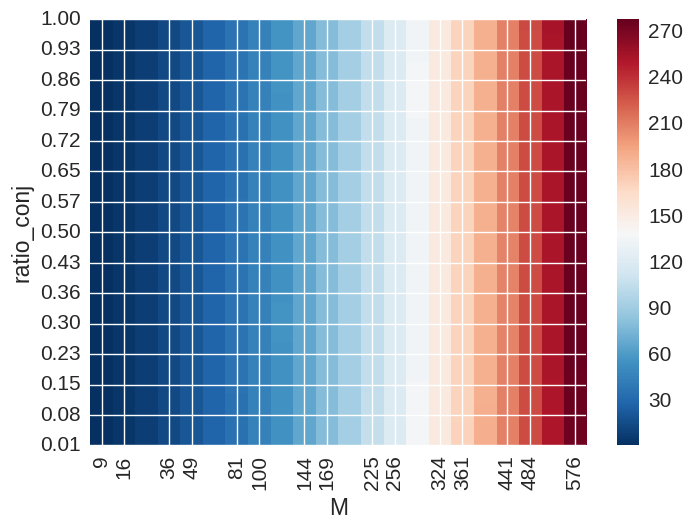

In [358]:
pcolor_2d_interpolated(df_avg, 'emfit_fidelity', y_col='ratio_conj')

## Comparison plot for specific M


In [368]:
def bars_fisherinfo_comparison(values_bars, values_bars_std, values_names, ax=None, mem_fidelity_bar=True):
    color_gen = sns.color_palette(palette='muted', n_colors=len(values_bars))
    # set_colormap = plt.cm.cubehelix

    bars_indices = np.arange(values_bars.size)
    width = 0.7

    ## Plot all as bars
    if ax is None:
        f, ax = plt.subplots(figsize=(12,6))

    for bar_i in xrange(values_bars.size):
        ax.bar(bars_indices[bar_i], values_bars[bar_i], width=width, color=color_gen[bar_i], zorder=2)
        ax.errorbar(bars_indices[bar_i] + width/2., 
                     values_bars[bar_i], 
                     yerr=values_bars_std[bar_i], 
                     ecolor='k', 
                     capsize=20, capthick=2, linewidth=2, zorder=3)

    # Add the memory fidelity multiplied by 2
    if mem_fidelity_bar:
        ax.bar(bars_indices[0], 
                2*values_bars[0], 
                width=width, 
                color=color_gen[0], 
                alpha=0.5, 
                hatch='/', linestyle='dashed', 
                zorder=1
               )
        ax.errorbar(bars_indices[0] + width/2., 
                     2*values_bars[0], 
                     yerr=2*values_bars_std[0], 
                     ecolor='k', 
                     alpha=0.3, 
                     capsize=20, capthick=2, 
                     linewidth=2, linestyle='--', fmt="none",
                     zorder=3
                    )

    ax.set_xticks(bars_indices + width/2.)
    ax.set_xticklabels(values_names)
    ax.set_xlim((-0.2, bars_indices.size))
    plt.tight_layout()
    
    return ax

In [375]:
target_M = 49

df_M = df_fits_filtered.groupby('M').mean().reset_index()
data_M = df_M[df_M.M == target_M].reset_index()
data_M

,index,M,precision,precision_sigma,precision_stddev,precision_stddev_sigma,fi_curv,fi_curv_sigma,fi_curv_stddev,fi_curv_stddev_sigma,...,emfit_fidelity_sigma,emfit_stddev,emfit_stddev_sigma,ratio_conj,fi_fidelity_ratio,fi_stddev_ratio,margfi_stddev_ratio,ratio_conj_qi,fi_marginal_half,fi_theo_half
0,4,49,21.610058,1.716308,0.30505,0.01204,45.960426,10.55577,0.214252,0.027637,...,1.729442,0.215216,0.00851,0.472145,0.978483,1.008708,1.008708,9.330508,21.226291,21.226291


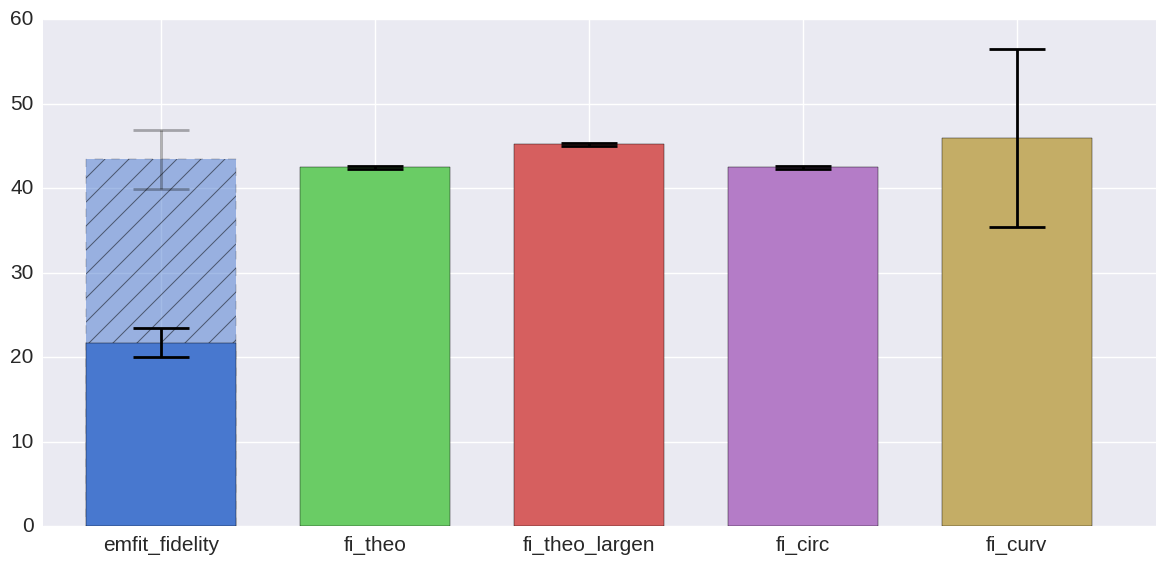

In [376]:
values_names = ["emfit_fidelity", "fi_theo", "fi_theo_largen", "fi_circ", "fi_curv"]

bars_fisherinfo_comparison(np.array([data_M[k] for k in values_names]), 
                           np.array([data_M[k + "_sigma"] for k in values_names]), 
                           values_names)

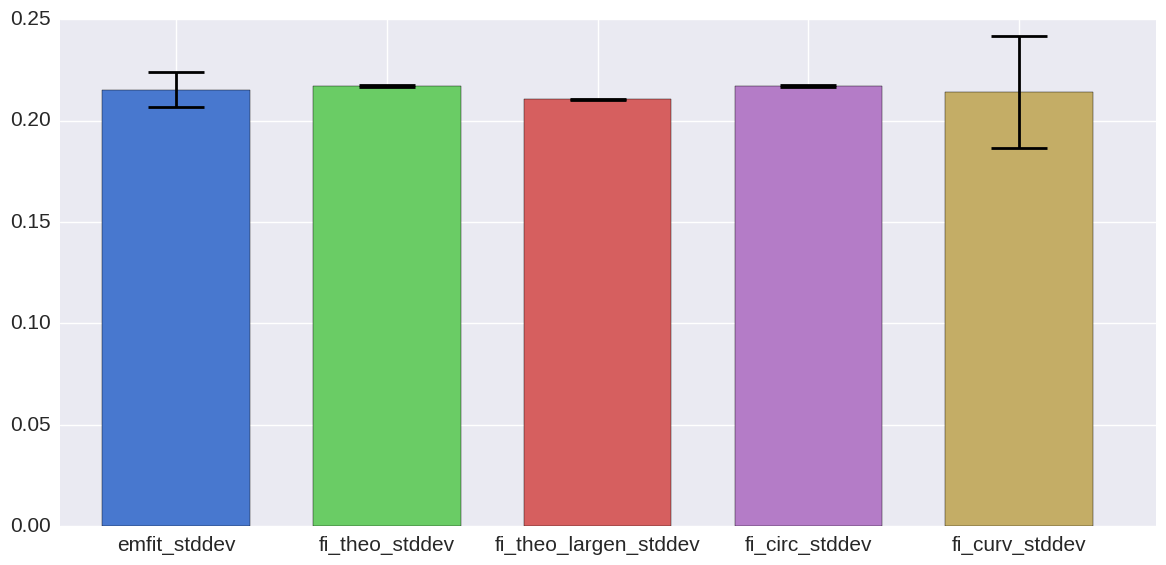

In [377]:
values_names = ["emfit_stddev", "fi_theo_stddev", "fi_theo_largen_stddev", "fi_circ_stddev", "fi_curv_stddev"]

bars_fisherinfo_comparison(np.array([data_M[k] for k in values_names]), 
                           np.array([data_M[k + "_sigma"] for k in values_names]), 
                           values_names, mem_fidelity_bar=False)